In [120]:
# Loading the required Libraries

from fastai.tabular import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from pandas_ml import ConfusionMatrix
from IPython.display import display

from sklearn import metrics, preprocessing
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

import re
import pandas as pd

from pandas.api.types import is_string_dtype, is_numeric_dtype

from hyperopt import *

from sklearn.preprocessing import Imputer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('mode.chained_assignment', None)

import matplotlib.pyplot as plt

In [2]:
PATH = 'E:/Desktop_07072019/Loan_LT/'

#### Loading Train and Test data

In [3]:
# %%time
train = pd.read_csv(f'{PATH}train.csv',low_memory = False)
test  = pd.read_csv(f'{PATH}test.csv',low_memory = False)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

In [5]:
test['loan_default'] = np.nan

In [6]:
# train size
train.shape

(233154, 41)

In [7]:
# test size
test.shape

(112392, 41)

### Custom Function Section

In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)
        
def calculate_months_from_strings(text):
    number_list = [int(s) for s in re.findall(r'\d+', text)]
    result = []
    for i in range(0,len(number_list)):
        if (i == 0):
            result.append(number_list[i] * 12)
        else:
            result.append(number_list[i])
    output = sum(result)
    return output

def get_stats(df,columns,bins=10):
    fig, axs = plt.subplots(1,2)
    for column in columns:
        df2 = df[np.isfinite(df[column])]
        count, division = np.histogram(df2[column],bins=bins)
        null_value_stats = df[df[column].isnull()]
        print(f"Column name: {column}")
        print(f"Total Rows: {len(df)}")
        print(f"Positive values row count: {len(df[(df[column]>=0)])}")
        print(f"Negative values row count: {len(df[(df[column]<0)])}")
        print(f"Null values row count: {null_value_stats.shape[0]}")
        print(f"Column summary")
        print(df[column].describe())
        print(f"Cut: {division}")
        print(f"Count: {count}")
        df.boxplot(column=[column], ax=axs[0])
        df[column].plot.hist(bins=10, alpha=0.5, ax=axs[1])

def target_encoded_labels(target, column_name, dataframe, name):
    df = dataframe[target].groupby(dataframe[column_name]).agg({name + '_category' : 'mean'})
    result = pd.qcut(df[name + '_category'], 4, labels=["good"
                                                       ,'medium'
                                                       ,'bad',
                                                       'worst']).reset_index()
    return result


def mean_encode(target, column_name, dataframe, name):
    df = dataframe[target].groupby(dataframe[column_name]).agg({ name + '_mean':'mean'})
    df.reset_index(inplace=True)
    return df

In [9]:
# Checking missing data
display_all(100*train.isnull().sum().sort_index()/len(train))

AVERAGE.ACCT.AGE                       0.000000
Aadhar_flag                            0.000000
CREDIT.HISTORY.LENGTH                  0.000000
Current_pincode_ID                     0.000000
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.000000
Date.of.Birth                          0.000000
DisbursalDate                          0.000000
Driving_flag                           0.000000
Employee_code_ID                       0.000000
Employment.Type                        3.285811
MobileNo_Avl_Flag                      0.000000
NEW.ACCTS.IN.LAST.SIX.MONTHS           0.000000
NO.OF_INQUIRIES                        0.000000
PAN_flag                               0.000000
PERFORM_CNS.SCORE                      0.000000
PERFORM_CNS.SCORE.DESCRIPTION          0.000000
PRI.ACTIVE.ACCTS                       0.000000
PRI.CURRENT.BALANCE                    0.000000
PRI.DISBURSED.AMOUNT                   0.000000
PRI.NO.OF.ACCTS                        0.000000
PRI.OVERDUE.ACCTS                      0

In [10]:
# test data
display_all(100*test.isnull().sum().sort_index()/len(test))

AVERAGE.ACCT.AGE                         0.000000
Aadhar_flag                              0.000000
CREDIT.HISTORY.LENGTH                    0.000000
Current_pincode_ID                       0.000000
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS      0.000000
Date.of.Birth                            0.000000
DisbursalDate                            0.000000
Driving_flag                             0.000000
Employee_code_ID                         0.000000
Employment.Type                          3.063385
MobileNo_Avl_Flag                        0.000000
NEW.ACCTS.IN.LAST.SIX.MONTHS             0.000000
NO.OF_INQUIRIES                          0.000000
PAN_flag                                 0.000000
PERFORM_CNS.SCORE                        0.000000
PERFORM_CNS.SCORE.DESCRIPTION            0.000000
PRI.ACTIVE.ACCTS                         0.000000
PRI.CURRENT.BALANCE                      0.000000
PRI.DISBURSED.AMOUNT                     0.000000
PRI.NO.OF.ACCTS                          0.000000


In [11]:
test.shape

(112392, 41)

In [12]:
# Viewing sample data
display_all(train.head(10))

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,Self employed,19-09-18,6,1998,1,1,0,0,0,0,825,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,Salaried,23-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,Salaried,16-09-18,6,1998,1,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,15-11-91,Self employed,05-09-18,6,1998,1,1,0,0,0,0,718,D-Very Low Risk,1,1,0,-41,365384,365384,0,0,0,0,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,510980,52603,61300,86.95,67,22807,45,1492,01-06-68,Salaried,16-09-18,6,1998,1,0,0,1,0,0,818,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


In [13]:
# Distribution of target variable
train['loan_default'].value_counts(normalize = True)

0    0.782929
1    0.217071
Name: loan_default, dtype: float64

In [14]:
# Appending train and test for creating new variables in their datasets
joined_df = train.append(test)

#### Data Preprocessing Step

In [15]:
# Converting String date columns to numerical months
joined_df['AVERAGE.ACCT.AGE'] = joined_df['AVERAGE.ACCT.AGE'].apply(calculate_months_from_strings)

In [16]:
joined_df['CREDIT.HISTORY.LENGTH'] = joined_df['CREDIT.HISTORY.LENGTH'].apply(calculate_months_from_strings)

In [17]:
# Formatting dates to python date format
joined_df['Date.of.Birth'] = pd.to_datetime(joined_df['Date.of.Birth']
                                           , dayfirst = True
                                           , infer_datetime_format = True
                                           , origin = 'unix')

joined_df['DisbursalDate'] = pd.to_datetime(joined_df['DisbursalDate']
                                           , dayfirst = True
                                           , infer_datetime_format = True
                                           , origin = 'unix')


In [18]:
# Fixing date conversion issues in date of birth column
joined_df['Date.of.Birth'] = np.where(joined_df['Date.of.Birth'].dt.year < 2010
                                     , joined_df['Date.of.Birth']
                                     ,joined_df['Date.of.Birth'] - pd.DateOffset(years = 100)
                                     )

#### Removing Outliers based on interquartile range

In [19]:
joined_df['disbursed_amount'] = np.clip(joined_df['disbursed_amount'], a_min = 25000, a_max = 80000)

In [20]:
joined_df['asset_cost'] = np.clip(joined_df['asset_cost'], a_min=45000, a_max = 100000)

In [21]:
joined_df['ltv'] = np.clip(joined_df['ltv'], a_min=40, a_max = 100)

In [22]:
joined_df['PERFORM_CNS.SCORE'] = np.clip(joined_df['PERFORM_CNS.SCORE'], a_min=300, a_max = 900)

In [23]:
joined_df['PRI.NO.OF.ACCTS'] = np.clip(joined_df['PRI.NO.OF.ACCTS'], a_min=0, a_max = 10)
joined_df['PRI.ACTIVE.ACCTS'] = np.clip(joined_df['PRI.ACTIVE.ACCTS'], a_min=0, a_max = 10)
joined_df['PRI.OVERDUE.ACCTS'] = np.clip(joined_df['PRI.OVERDUE.ACCTS'], a_min=0, a_max = 5)

In [24]:
joined_df['PRI.CURRENT.BALANCE'] = np.clip(joined_df['PRI.CURRENT.BALANCE'], a_min=0, a_max = 500000)
joined_df['PRI.SANCTIONED.AMOUNT'] = np.clip(joined_df['PRI.SANCTIONED.AMOUNT'], a_min=0, a_max = 500000)
joined_df['PRI.DISBURSED.AMOUNT'] = np.clip(joined_df['PRI.DISBURSED.AMOUNT'], a_min=0, a_max = 500000)

In [25]:
joined_df['SEC.NO.OF.ACCTS'] = np.clip(joined_df['SEC.NO.OF.ACCTS'], a_min=0, a_max = 5)
joined_df['SEC.ACTIVE.ACCTS'] = np.clip(joined_df['SEC.ACTIVE.ACCTS'], a_min=0, a_max = 3)
joined_df['SEC.OVERDUE.ACCTS'] = np.clip(joined_df['SEC.OVERDUE.ACCTS'], a_min=0, a_max = 1)

In [26]:
joined_df['SEC.CURRENT.BALANCE'] = np.clip(joined_df['SEC.CURRENT.BALANCE'], a_min=0, a_max = 100000)
joined_df['SEC.SANCTIONED.AMOUNT'] = np.clip(joined_df['SEC.SANCTIONED.AMOUNT'], a_min=0, a_max = 100000)
joined_df['SEC.DISBURSED.AMOUNT'] = np.clip(joined_df['SEC.DISBURSED.AMOUNT'], a_min=0, a_max = 100000)

In [27]:
joined_df['PRIMARY.INSTAL.AMT'] = np.clip(joined_df['PRIMARY.INSTAL.AMT'], a_min=0, a_max = 10000)
joined_df['SEC.INSTAL.AMT'] = np.clip(joined_df['SEC.INSTAL.AMT'], a_min=0, a_max = 2000)

In [28]:
joined_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'] = np.clip(joined_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'], a_min=0, a_max = 4)
joined_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = np.clip(joined_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'], a_min=0, a_max = 2)

In [29]:
joined_df['AVERAGE.ACCT.AGE'] = np.clip(joined_df['AVERAGE.ACCT.AGE'], a_min=0, a_max = 48)
joined_df['CREDIT.HISTORY.LENGTH'] = np.clip(joined_df['CREDIT.HISTORY.LENGTH'], a_min=0, a_max = 120)
joined_df['NO.OF_INQUIRIES'] = np.clip(joined_df['NO.OF_INQUIRIES'], a_min=0, a_max = 4)

#### Feature Engineering

In [30]:
# Creating customer age column at the time of disbursaldate
joined_df['customer_age'] = round((joined_df['DisbursalDate'] - joined_df['Date.of.Birth']).dt.days / 365.2425)

In [31]:
# Fixing missing value in Employment Type Column
joined_df['Employment.Type'] = joined_df['Employment.Type'].fillna('Unidentified')
joined_df['Employment.Type_NA'] = np.where(joined_df['Employment.Type'] == 'Unidentified'
                                    ,True
                                    ,False
                                    )

In [32]:
# loan and disbursed amount based features
joined_df['dtv'] = round(100*joined_df['disbursed_amount']/joined_df['asset_cost'],2)
joined_df['diff_ltv_dtv'] = joined_df['ltv'] - joined_df['dtv']
joined_df['loan_amt'] = joined_df['ltv'] * joined_df['asset_cost']
joined_df['high_loan_flag'] = np.where(joined_df['loan_amt'] > joined_df['disbursed_amount'], 1, 0)
joined_df.drop('loan_amt',axis=1, inplace=True) # dropping due to high correlation with disbursed amt

In [33]:
# Creating categories based on bureau description
joined_df['Bureau_categories'] = np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very Low Risk')
                                  ,'Very Low Risk'
                                  ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Low Risk')
                                           ,'Low Risk'
                                           ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Medium Risk')
                                                    ,'Medium Risk'
                                                    ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very High Risk')
                                                             ,'Very High Risk'
                                                             ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('High Risk')
                                                             ,'High Risk'
                                                             ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')
                                                             ,'Not Scored'
                                                             ,'No History'
                                                             )
                                                             )
                                                             )
                                                    )
                                           )
                                 )

In [34]:
# Creating some flags based on account activity
train['recent_bad_accnt_flag'] = np.where(train['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] > 0, 1, 0)
train['recent_open_accnt_flag'] = np.where(train['NEW.ACCTS.IN.LAST.SIX.MONTHS'] > 0, 1, 0)
train['inquire_flag'] = np.where(train['NO.OF_INQUIRIES'] > 0, 1, 0)
train['id_score'] = (train['Aadhar_flag'] + train['PAN_flag'] + train['VoterID_flag'] + 
                        train['Driving_flag'] + train['Passport_flag'])
train['Bureau_categories'] = np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very Low Risk')
                                  ,'Very Low Risk'
                                  ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Low Risk')
                                           ,'Low Risk'
                                           ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Medium Risk')
                                                    ,'Medium Risk'
                                                    ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very High Risk')
                                                             ,'Very High Risk'
                                                             ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('High Risk')
                                                             ,'High Risk'
                                                             ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')
                                                             ,'Not Scored'
                                                             ,'No History'
                                                             )
                                                             )
                                                             )
                                                    )
                                           )
                                 )
train['AVERAGE.ACCT.AGE'] = train['AVERAGE.ACCT.AGE'].apply(calculate_months_from_strings)
train['Employment.Type'] = train['Employment.Type'].fillna('Unidentified')

In [35]:
# Creating some flags based on account activity
train['recent_bad_accnt_flag'] = np.where(train['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] > 0, 1, 0)
train['recent_open_accnt_flag'] = np.where(train['NEW.ACCTS.IN.LAST.SIX.MONTHS'] > 0, 1, 0)
train['inquire_flag'] = np.where(train['NO.OF_INQUIRIES'] > 0, 1, 0)
train['id_score'] = (train['Aadhar_flag'] + train['PAN_flag'] + train['VoterID_flag'] + 
                        train['Driving_flag'] + train['Passport_flag'])
train['Bureau_categories'] = np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very Low Risk')
                                  ,'Very Low Risk'
                                  ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Low Risk')
                                           ,'Low Risk'
                                           ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Medium Risk')
                                                    ,'Medium Risk'
                                                    ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very High Risk')
                                                             ,'Very High Risk'
                                                             ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('High Risk')
                                                             ,'High Risk'
                                                             ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')
                                                             ,'Not Scored'
                                                             ,'No History'
                                                             )
                                                             )
                                                             )
                                                    )
                                           )
                                 )


In [36]:
train['Employment.Type'] = train['Employment.Type'].fillna('Unidentified')

In [37]:
# Creating ID based score
joined_df['id_score'] = (joined_df['Aadhar_flag'] + joined_df['PAN_flag'] + joined_df['VoterID_flag'] + 
                        joined_df['Driving_flag'] + joined_df['Passport_flag'])

In [38]:
train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'recent_bad_accnt_flag', 'recent_open_accnt_flag',
       'inquire_flag', 'id_score', 'Bureau_ca

In [39]:
# dataframes based on bureau scores
branch_bs = mean_encode('PERFORM_CNS.SCORE', 'branch_id', train, 'brnch_bureau_score')
supplier_bs = mean_encode('PERFORM_CNS.SCORE', 'supplier_id', train, 'supp_bureau_score')
manufacturer_bs = mean_encode('PERFORM_CNS.SCORE', 'manufacturer_id', train, 'manuf_bureau_score')
pincode_bs = mean_encode('PERFORM_CNS.SCORE', 'Current_pincode_ID', train, 'pin_bureau_score')
state_bs = mean_encode('PERFORM_CNS.SCORE', 'State_ID', train, 'state_bureau_score')
employee_bs = mean_encode('PERFORM_CNS.SCORE', 'Employee_code_ID', train, 'emp_bureau_score')
employ_type_bs = mean_encode('PERFORM_CNS.SCORE', 'Employment.Type', train, 'emptype_bureau_score')
id_bs = mean_encode('PERFORM_CNS.SCORE', 'id_score', train, 'id_bureau_score')
bureau_bs = mean_encode('PERFORM_CNS.SCORE', 'Bureau_categories', train, 'bc_bureau_score')


In [40]:
# dataframes based on delinquent accounts
branch_da = mean_encode('recent_bad_accnt_flag', 'branch_id', train, 'brnch_delinq')
supplier_da = mean_encode('recent_bad_accnt_flag', 'supplier_id', train, 'supp_delinq')
manufacturer_da = mean_encode('recent_bad_accnt_flag', 'manufacturer_id', train, 'manuf_delinq')
pincode_da = mean_encode('recent_bad_accnt_flag', 'Current_pincode_ID', train, 'pin_delinq')
state_da = mean_encode('recent_bad_accnt_flag', 'State_ID', train, 'state_delinq')
employee_da = mean_encode('recent_bad_accnt_flag', 'Employee_code_ID', train, 'employ_delinq')
employ_type_da = mean_encode('recent_bad_accnt_flag', 'Employment.Type', train, 'emptype_delinq')
id_da = mean_encode('recent_bad_accnt_flag', 'id_score', train, 'id_delinq')
bureau_da = mean_encode('recent_bad_accnt_flag', 'Bureau_categories', train, 'bc_delinq')

In [41]:
# dataframes based on recent created accounts
branch_nac = mean_encode('recent_open_accnt_flag', 'branch_id', train, 'brnch_new_acc')
supplier_nac = mean_encode('recent_open_accnt_flag', 'supplier_id', train, 'supp_new_acc')
manufacturer_nac = mean_encode('recent_open_accnt_flag', 'manufacturer_id', train, 'manuf_new_acc')
pincode_nac = mean_encode('recent_open_accnt_flag', 'Current_pincode_ID', train, 'pin_new_acc')
state_nac = mean_encode('recent_open_accnt_flag', 'State_ID', train, 'state_new_acc')
employee_nac = mean_encode('recent_open_accnt_flag', 'Employee_code_ID', train, 'employ_new_acc')
employ_type_nac = mean_encode('recent_open_accnt_flag', 'Employment.Type', train, 'emptype_new_acc')
id_nac = mean_encode('recent_open_accnt_flag', 'id_score', train, 'id_new_acc')
bureau_nac = mean_encode('recent_open_accnt_flag', 'Bureau_categories', train, 'bc_new_acc')


In [42]:
# dataframes based on recent inquries
branch_inq = mean_encode('inquire_flag', 'branch_id', train, 'brnch_inquire')
supplier_inq = mean_encode('inquire_flag', 'supplier_id', train, 'supp_inquire')
manufacturer_inq = mean_encode('inquire_flag', 'manufacturer_id', train, 'manuf_inquire')
pincode_inq = mean_encode('inquire_flag', 'Current_pincode_ID', train, 'pin_inquire')
state_inq = mean_encode('inquire_flag', 'State_ID', train, 'state_inquire')
employee_inq = mean_encode('inquire_flag', 'Employee_code_ID', train, 'employ_inquire')
employ_type_inq = mean_encode('inquire_flag', 'Employment.Type', train, 'emptype_inquire')
id_inq = mean_encode('inquire_flag', 'id_score', train, 'id_inquire')
bureau_inq = mean_encode('inquire_flag', 'Bureau_categories', train, 'bc_inquire')

In [43]:
# dataframes based on account age
branch_aa = mean_encode('AVERAGE.ACCT.AGE', 'branch_id', train, 'brnch_acc_age')
supplier_aa = mean_encode('AVERAGE.ACCT.AGE', 'supplier_id', train, 'supp_acc_age')
manufacture_aa = mean_encode('AVERAGE.ACCT.AGE', 'manufacturer_id', train, 'manuf_acc_age')
pincode_aa = mean_encode('AVERAGE.ACCT.AGE', 'Current_pincode_ID', train, 'pin_acc_age')
state_aa = mean_encode('AVERAGE.ACCT.AGE', 'State_ID', train, 'state_acc_age')
employee_aa = mean_encode('AVERAGE.ACCT.AGE', 'Employee_code_ID', train, 'employ_acc_age')
employ_type_aa = mean_encode('AVERAGE.ACCT.AGE', 'Employment.Type', train, 'emptype_acc_age')
id_aa = mean_encode('AVERAGE.ACCT.AGE', 'id_score', train, 'id_acc_age')
bureau_aa = mean_encode('AVERAGE.ACCT.AGE', 'Bureau_categories', train, 'bc_acc_age')

In [44]:
# dataframes based on ltv
branch_ltv = mean_encode('ltv', 'branch_id', train, 'brnch_ltv')
supplier_ltv = mean_encode('ltv', 'supplier_id', train, 'supp_ltv')
manufacture_ltv = mean_encode('ltv', 'manufacturer_id', train, 'manuf_ltv')
pincode_ltv = mean_encode('ltv', 'Current_pincode_ID', train, 'pin_ltv')
state_ltv = mean_encode('ltv', 'State_ID', train, 'state_ltv')
employee_ltv = mean_encode('ltv', 'Employee_code_ID', train, 'employ_ltv')
employ_type_ltv = mean_encode('ltv', 'Employment.Type', train, 'emptype_ltv')
id_ltv = mean_encode('ltv', 'id_score', train, 'id_ltv')
bureau_ltv = mean_encode('ltv', 'Bureau_categories', train, 'bc_ltv')

In [45]:
# dataframes based on disbursed amt
branch_disamt = mean_encode('disbursed_amount', 'branch_id', train, 'brnch_disamt')
supplier_disamt = mean_encode('disbursed_amount', 'supplier_id', train, 'supp_disamt')
manufacture_disamt = mean_encode('disbursed_amount', 'manufacturer_id', train, 'manuf_disamt')
pincode_disamt = mean_encode('disbursed_amount', 'Current_pincode_ID', train, 'pin_disamt')
state_disamt = mean_encode('disbursed_amount', 'State_ID', train, 'state_disamt')
employee_disamt = mean_encode('disbursed_amount', 'Employee_code_ID', train, 'employ_disamt')
employ_type_disamt = mean_encode('disbursed_amount', 'Employment.Type', train, 'emptype_disamt')
id_disamt = mean_encode('disbursed_amount', 'id_score', train, 'id_disamt')
bureau_disamt = mean_encode('disbursed_amount', 'Bureau_categories', train, 'bc_disamt')

In [46]:
# dataframes based on asset cost
branch_ass = mean_encode('asset_cost', 'branch_id', train, 'brnch_ass')
supplier_ass = mean_encode('asset_cost', 'supplier_id', train, 'supp_ass')
manufacture_ass = mean_encode('asset_cost', 'manufacturer_id', train, 'manuf_ass')
pincode_ass = mean_encode('asset_cost', 'Current_pincode_ID', train, 'pin_ass')
state_ass = mean_encode('asset_cost', 'State_ID', train, 'state_ass')
employee_ass = mean_encode('asset_cost', 'Employee_code_ID', train, 'employ_ass')
employ_type_ass = mean_encode('asset_cost', 'Employment.Type', train, 'emptype_ass')
id_ass = mean_encode('asset_cost', 'id_score', train, 'id_ass')
bureau_ass = mean_encode('asset_cost', 'Bureau_categories', train, 'bc_ass')

#### Joining the created dataframes with main dataframe

In [47]:
joined_df = pd.merge(joined_df, branch_bs, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_bs, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacturer_bs, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_bs, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_bs, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_bs, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_bs, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_bs, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_bs, how='left', on='Bureau_categories')

In [48]:
joined_df = pd.merge(joined_df, branch_da, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_da, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacturer_da, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_da, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_da, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_da, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_da, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_da, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_da, how='left', on='Bureau_categories')

In [49]:
joined_df = pd.merge(joined_df, branch_nac, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_nac, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacturer_nac, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_nac, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_nac, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_nac, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_nac, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_nac, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_nac, how='left', on='Bureau_categories')

In [50]:
joined_df = pd.merge(joined_df, branch_inq, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_inq, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacturer_inq, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_inq, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_inq, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_inq, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_inq, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_inq, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_inq, how='left', on='Bureau_categories')

In [51]:
joined_df = pd.merge(joined_df, branch_aa, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_aa, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacture_aa, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_aa, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_aa, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_aa, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_aa, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_aa, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_aa, how='left', on='Bureau_categories')

In [52]:
joined_df = pd.merge(joined_df, branch_ltv, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_ltv, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacture_ltv, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_ltv, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_ltv, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_ltv, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_ltv, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_ltv, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_ltv, how='left', on='Bureau_categories')

In [53]:
joined_df = pd.merge(joined_df, branch_disamt, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_disamt, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacture_disamt, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_disamt, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_disamt, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_disamt, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_disamt, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_disamt, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_disamt, how='left', on='Bureau_categories')

In [54]:
joined_df = pd.merge(joined_df, branch_ass, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_ass, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacture_ass, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_ass, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_ass, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_ass, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_ass, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_ass, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_ass, how='left', on='Bureau_categories')

In [55]:
print(joined_df.shape)
display_all(joined_df.head(10))

(345546, 120)


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,customer_age,Employment.Type_NA,dtv,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,bc_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,state_delinq_mean,employ_delinq_mean,emptype_delinq_mean,id_delinq_mean,bc_delinq_mean,brnch_new_acc_mean,supp_new_acc_mean,manuf_new_acc_mean,pin_new_acc_mean,state_new_acc_mean,employ_new_acc_mean,emptype_new_acc_mean,id_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,state_inquire_mean,employ_inquire_mean,emptype_inquire_mean,id_inquire_mean,bc_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,manuf_acc_age_mean,pin_acc_age_mean,state_acc_age_mean,employ_acc_age_mean,emptype_acc_age_mean,id_acc_age_mean,bc_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,state_ltv_mean,employ_ltv_mean,emptype_ltv_mean,id_ltv_mean,bc_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,emptype_disamt_mean,id_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,manuf_ass_mean,pin_ass_mean,state_ass_mean,employ_ass_mean,emptype_ass_mean,id_ass_mean,bc_ass_mean
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,2018-08-03,6,1998,1,1,0,0,0,0,300,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,35.0,False,86.61,2.94,1,No History,1,343.164107,395.345455,264.749285,205.555556,346.743471,360.037037,310.417830,287.950246,0.000000,0.069474,0.054545,0.070339,0.000000,0.082406,0.055556,0.077725,0.077923,0.000855,0.259269,0.218182,0.196447,0.055556,0.255783,0.203704,0.233921,0.219988,0.001967,0.168785,0.290909,0.144704,0.055556,0.164393,0.296296,0.140786,0.131816,0.059359,8.324329,13.254545,8.051814,6.444444,9.337412,12.759259,9.032312,8.838188,0.277879,77.120983,84.185636,76.125157,75.091111,77.283698,83.360741,76.210719,74.854666,73.583376,51916.069297,53670.0,49201.774679,48856.722222,51410.941203,53548.740741,54534.755493,54319.040972,54067.189397,69270.290519,65188.854545,67026.151008,66971.944444,68775.013849,65764.333333,74395.277034,75640.051357,76760.599761
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,23,23,0,1.0,33.0,False,71.92,1.31,1,Medium Risk,1,343.164107,395.345455,264.749285,374.714286,346.743471,360.037037,279.717178,287.950246,603.511360,0.069474,0.054545,0.070339,0.285714,0.082406,0.055556,0.080229,0.077923,0.293345,0.259269,0.218182,0.196447,0.285714,0.255783,0.203704,0.216696,0.219988,0.372382,0.168785,0.290909,0.144704,0.142857,0.164393,0.296296,0.131046,0.131816,0.186432,8.324329,13.254545,8.051814,10.000000,9.337412,12.759259,9.025228,8.838188,21.344989,77.120983,84.185636,76.125157,81.090000,77.283698,83.360741,73.730119,74.854666,76.209207,51916.069297,53670.0,49201.774679,51740.857143,51410.941203,53548.740741,54015.298022,54319.040972,55095.285772,69270.290519,65188.854545,67026.151008,65336.000000,68775.013849,65764.333333,76578.664175,75640.051357,75341.339349
2,417566,53278,61360,89.63,67,22807,45,

In [56]:
# Combining primary accounts and secondary accounts related columns into total accounts
joined_df['total_accounts'] = joined_df['PRI.NO.OF.ACCTS'] + joined_df['SEC.NO.OF.ACCTS']
joined_df['total_act_accounts'] = joined_df['PRI.ACTIVE.ACCTS'] + joined_df['SEC.ACTIVE.ACCTS']
joined_df['total_od_accounts'] = joined_df['PRI.OVERDUE.ACCTS'] + joined_df['SEC.OVERDUE.ACCTS']
joined_df['total_cur_balance'] = joined_df['PRI.CURRENT.BALANCE'] + joined_df['SEC.CURRENT.BALANCE']
joined_df['total_sanc_amt'] = joined_df['PRI.SANCTIONED.AMOUNT'] + joined_df['SEC.SANCTIONED.AMOUNT']
joined_df['total_disb_amt'] = joined_df['PRI.DISBURSED.AMOUNT'] + joined_df['SEC.DISBURSED.AMOUNT']
joined_df['total_emi'] = joined_df['PRIMARY.INSTAL.AMT'] + joined_df['SEC.INSTAL.AMT']

In [57]:
# Creating paid percent based on disbursed amount and current balance
joined_df['paid_percent'] = np.where(joined_df['total_disb_amt'] > 0
                                    ,(joined_df['total_disb_amt'] - joined_df['total_cur_balance'])
                                     / joined_df['total_disb_amt']
                                    ,joined_df['total_disb_amt']
                                    )
# Creating instalment ratio feature
joined_df['instalment_ratio'] = np.where(joined_df['total_cur_balance'] > 0
                                              ,joined_df['total_emi']/joined_df['total_cur_balance']
                                              ,joined_df['total_cur_balance']
                                             )

In [58]:
# Creating account ratios based on account activity
joined_df['overdue_ratio'] = np.where(
                                    joined_df['total_accounts'] > 0
                                    ,joined_df['total_od_accounts']/joined_df['total_accounts']
                                    ,joined_df['total_accounts']
                                    )

joined_df['active_ratio'] = np.where(np.logical_and(joined_df['total_accounts'] > 0
                                                    , joined_df['total_act_accounts'] > 0)
                                    ,(joined_df['total_act_accounts'] - joined_df['total_od_accounts'])
                                    /joined_df['total_accounts']
                                    ,0
                                    )
joined_df['active_ratio'] = np.clip(joined_df['active_ratio'], a_min=0, a_max = 1)

joined_df['success_ratio'] = np.where(
                                    joined_df['total_accounts'] == joined_df['total_act_accounts']
                                    ,0
                                    ,np.where(joined_df['total_accounts'] > 0
                                              ,(joined_df['total_accounts'] - joined_df['total_act_accounts'])
                                              /joined_df['total_accounts']
                                              ,joined_df['total_accounts']
                                    )
                                    )

joined_df['instalment_flag'] = np.where(np.logical_and(joined_df['PRIMARY.INSTAL.AMT'] > 0
                                                    , joined_df['SEC.INSTAL.AMT'] > 0)
                                             ,1
                                             ,0
                                             )

In [59]:
# Features based on disbursed amounts
joined_df['avg_disbursed_amt'] = np.where(joined_df['total_accounts'] > 0
                                          ,joined_df['total_disb_amt']/joined_df['total_accounts']
                                          ,joined_df['total_accounts']
                                         )
joined_df['more_disbursed_flag'] = np.where(joined_df['disbursed_amount'] > joined_df['avg_disbursed_amt'], 1, 0)

joined_df['disbursed_amt_diff'] = joined_df['disbursed_amount'] - joined_df['avg_disbursed_amt']

In [60]:
# Features based on sanctioned amounts
joined_df['same_sanctioned_flag'] = np.where(joined_df['total_sanc_amt'] == joined_df['total_disb_amt']
                                         ,True
                                         ,False
                                        )
joined_df['sanc_amt_diff'] = joined_df['total_sanc_amt'] - joined_df['total_disb_amt']

In [61]:
# Features based on instalment amounts
joined_df['avg_instalment'] = np.where(joined_df['AVERAGE.ACCT.AGE'] > 0
                                        ,joined_df['total_disb_amt']/joined_df['AVERAGE.ACCT.AGE']
                                        ,joined_df['AVERAGE.ACCT.AGE']
                                       )
joined_df['more_instalment_flag'] = np.where(joined_df['total_emi'] > joined_df['avg_instalment'], 1, 0)

In [62]:
# Other Miscellaneous Features
joined_df['young_risk_cust'] = np.where(np.logical_and(joined_df['customer_age'] < 25
                                                       ,joined_df['CREDIT.HISTORY.LENGTH'] == 0
                                                      )
                                       ,True
                                       ,False
                                       )

In [63]:
# Dropping unneccesary columns
joined_df.drop( ['PRI.NO.OF.ACCTS'
                          ,'PRI.ACTIVE.ACCTS'
                          ,'PRI.OVERDUE.ACCTS'
                          ,'PRI.CURRENT.BALANCE'
                          ,'PRI.SANCTIONED.AMOUNT'
                          ,'PRI.DISBURSED.AMOUNT'
                          ,'SEC.NO.OF.ACCTS'
                          ,'SEC.ACTIVE.ACCTS'
                          ,'SEC.OVERDUE.ACCTS'
                          ,'SEC.CURRENT.BALANCE'
                          ,'SEC.SANCTIONED.AMOUNT'
                          ,'SEC.DISBURSED.AMOUNT'
                          ,'PRIMARY.INSTAL.AMT'
                          ,'SEC.INSTAL.AMT'
                          ,'total_sanc_amt'
                          ,'disbursed_amt_diff'
                          ,'total_od_accounts'
                          ,'Aadhar_flag'
                          ,'PAN_flag'
                          ,'VoterID_flag'
                          ,'Driving_flag'
                          ,'Passport_flag'
                          ,'supplier_id'
                          ,'Current_pincode_ID'
                          ,'Employee_code_ID'
                          ,'MobileNo_Avl_Flag'
                         ]
               , axis=1
               , inplace=True
              )

#### Checking data in columns

In [64]:
joined_df['loan_default'].groupby(joined_df['Bureau_categories']).agg('mean')

Bureau_categories
High Risk         0.270104
Low Risk          0.183995
Medium Risk       0.255640
No History        0.231313
Not Scored        0.215271
Very High Risk    0.301816
Very Low Risk     0.158059
Name: loan_default, dtype: float64

In [65]:
joined_df['Employment.Type'].value_counts()

Self employed    187429
Salaried         147013
Unidentified      11104
Name: Employment.Type, dtype: int64

In [66]:
min(joined_df['Date.of.Birth']), max(joined_df['Date.of.Birth'])

(Timestamp('1949-09-15 00:00:00'), Timestamp('2000-11-29 00:00:00'))

In [67]:
min(joined_df['DisbursalDate']), max(joined_df['DisbursalDate'])

(Timestamp('2018-08-01 00:00:00'), Timestamp('2018-11-30 00:00:00'))

In [68]:
#viewing the distribution of dates in DisbursalDate column
joined_df['DisbursalDate'].groupby([joined_df['DisbursalDate'].dt.year
                                    , joined_df['DisbursalDate'].dt.month
                                   ]).agg({'count'})

count
DisbursalDate DisbursalDate        
2018          8               68002
              9               66788
              10              98364
              11             112392

In [69]:
# Create correlation matrix
corr_matrix = joined_df._get_numeric_data().corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('Dropping following columns due to high correlation')
print(to_drop)
# Dropping highly correlated columns
joined_df.drop(to_drop, axis=1, inplace=True)

Dropping following columns due to high correlation
['dtv', 'bc_bureau_score_mean', 'state_delinq_mean', 'emptype_delinq_mean', 'brnch_new_acc_mean', 'manuf_new_acc_mean', 'state_new_acc_mean', 'emptype_new_acc_mean', 'id_new_acc_mean', 'state_inquire_mean', 'emptype_inquire_mean', 'id_inquire_mean', 'bc_inquire_mean', 'manuf_acc_age_mean', 'state_acc_age_mean', 'emptype_acc_age_mean', 'id_acc_age_mean', 'bc_acc_age_mean', 'state_ltv_mean', 'id_ltv_mean', 'bc_ltv_mean', 'emptype_disamt_mean', 'id_disamt_mean', 'manuf_ass_mean', 'state_ass_mean', 'emptype_ass_mean', 'id_ass_mean', 'bc_ass_mean', 'total_disb_amt']


In [70]:
display_all(corr_matrix)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,customer_age,Employment.Type_NA,dtv,diff_ltv_dtv,high_loan_flag,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,bc_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,state_delinq_mean,employ_delinq_mean,emptype_delinq_mean,id_delinq_mean,bc_delinq_mean,brnch_new_acc_mean,supp_new_acc_mean,manuf_new_acc_mean,pin_new_acc_mean,state_new_acc_mean,employ_new_acc_mean,emptype_new_acc_mean,id_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,state_inquire_mean,employ_inquire_mean,emptype_inquire_mean,id_inquire_mean,bc_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,manuf_acc_age_mean,pin_acc_age_mean,state_acc_age_mean,employ_acc_age_mean,emptype_acc_age_mean,id_acc_age_mean,bc_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,state_ltv_mean,employ_ltv_mean,emptype_ltv_mean,id_ltv_mean,bc_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,emptype_disamt_mean,id_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,manuf_ass_mean,pin_ass_mean,state_ass_mean,employ_ass_mean,emptype_ass_mean,id_ass_mean,bc_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_disb_amt,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
UniqueID,1.000000,0.127837,0.125275,0.005840,0.032785,0.021455,0.029357,0.009019,0.033793,0.010155,0.008733,0.020159,0.022370,0.033848,0.017595,0.003525,0.030829,0.076539,NaN,0.159610,0.016037,0.006768,0.011244,0.007180,0.026650,0.000082,0.004980,0.136277,0.011554,0.001722,0.004052,0.010293,0.011112,0.009055,0.000996,0.002728,0.042957,0.009286,0.003214,0.004557,0.012218,0.014314,0.018549,0.007961,0.004865,0.152870,0.019965,0.016708,0.019886,0.021716,0.003617,0.042882,0.017397,0.004860,0.152865,0.018732,0.026769,0.009440,0.016710,0.002207,0.021124,0.010594,0.003545,0.160822,0.015887,0.015358,0.012274,0.004271,0.010211,0.014589,0.005675,0.004369,0.160612,0.016971,0.022731,0.013575,0.020994,0.009253,0.043678,0.000464,0.001917,0.155401,0.015231,0.029016,0.018499,0.016652,0.016791,0.038981,0.006505,0.005003,0.159070,0.012946,0.030770,0.039279,0.024949,0.027135,0.018154,0.001452,0.001513,0.000262,0.027352,0.001473,0.040632,0.011178,0.026542,0.006913,0.016006,0.024144,0.009189,0.004180
disbursed_amount,0.127837,1.000000,0.700283,0.451040,0.015028,0.118045,0.038829,0.003807,0.036202,0.021656,0.001717,0.009148,0.047829,0.088241,0.058932,0.046854,0.611199,0.445925,NaN,0.012965,0.019392,0.005989,0.065546,0.010117,0.029244,0.004096,0.018801,0.011180,0.012922,0.009630,0.041272,0.178708,0.008474,0.003473,0.023963,0.051857,0.002984,0.032750,0.004103,0.034551,0.099275,0.011348,0.011982,0.022293,0.024920,0.011823,0.020586,0.049354,0.013096,0.104694,0.020466,0.068029,0.016368,0.025137,0.012095,0.025064,0.013491,0.017864,0.176797,0.010111,0.014462,0.002041,0.046684,0.013240,0.029530,0.061051,0.026132,0.224497,0.088991,0.022418,0.048893,0.016374,0.013044,0.028373,0.304549,0.454735,0.303225,0.343221,0.233227,0.394654,0.054526,0.012329,0.036332,0.177985,0.379506,0.305976,0.213769,0.125868,0.295647,0.016649,0.012771,0.012834,0.034634,0.036798,0.012446,0.014719,0.023959,0.002674,0.000361,0.011319,0.022289,0.004240,0.011744,0.000660,0.087832,0.003244,0.008687,0.019539,0.004285,0.051195
asset_cost,0.125275,0.700283,1.000000,0.274693,0.001550,0.059426,0.048787,0.057121,0.029943,0.013004,0.033551,0.038523,0.027818,0.017969,0.131

In [71]:
#splitting the joined_df back to original train and test dataframes
train_df = joined_df[:len(train)]
test_df = joined_df[len(train):]
train_df.shape, test_df.shape

((233154, 86), (112392, 86))

In [72]:
#sorting training data by disbursal date
train_df.sort_values(by=['DisbursalDate'], inplace = True)

In [73]:
display_all(train_df.head(10))

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,customer_age,Employment.Type_NA,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,employ_delinq_mean,id_delinq_mean,bc_delinq_mean,supp_new_acc_mean,pin_new_acc_mean,employ_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,employ_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,pin_acc_age_mean,employ_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,employ_ltv_mean,emptype_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,pin_ass_mean,employ_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
51815,417581,49803,68826,74.10,77,86,1990-01-12,Salaried,2018-08-01,4,300,No Bureau History Available,0,0,0,0,1,1.0,29.0,False,1.74,1,No History,1,297.445675,342.018405,311.375801,381.000000,328.521484,276.345455,310.41783,287.950246,0.081661,0.116564,0.080368,0.000000,0.109091,0.077923,0.000855,0.263804,0.333333,0.163636,0.001967,0.118339,0.092025,0.134734,0.166667,0.054545,10.723875,11.607362,14.666667,11.036364,78.087855,78.290736,77.077806,76.566667,75.622727,76.210719,55691.985467,57949.380368,54334.505788,51711.000000,57014.351036,58799.509091,54067.189397,74192.112803,75964.294479,69587.500000,79831.763636,0,0,0,0,0.000000,0.00,0.0,0.00,0.00,0,0.0,1,True,0,0.000000,0,False
165407,418698,62635,75886,83.77,136,86,1983-05-27,Salaried,2018-08-01,8,300,Not Scored: Not Enough Info available on the c...,1,0,2,2,0,0.0,35.0,False,1.23,1,Not Scored,1,372.686965,415.130268,311.375801,440.948718,372.651194,390.495726,310.41783,287.950246,0.121920,0.122605,0.080368,0.153846,0.119658,0.077923,0.028516,0.360153,0.410256,0.376068,0.580055,0.147325,0.099617,0.134734,0.051282,0.128205,11.629516,11.862069,15.025641,11.777778,77.219847,81.004330,77.077806,78.401026,80.896581,76.210719,57202.792417,56769.563218,54334.505788,52423.384615,57790.942171,55695.829060,54679.881184,76280.826631,71541.551724,67813.230769,70426.871795,1,1,25200,0,0.400000,0.00,0.0,1.00,0.00,0,42000.0,1,True,0,21000.000000,0,False
59430,418913,55959,67100,84.95,19,45,1983-01-01,Salaried,2018-08-01,4,737,C-Very Low Risk,0,0,26,44,0,0.0,36.0,False,1.55,1,Very Low Risk,1,380.756143,400.611111,264.749285,438.757282,328.521484,380.292683,310.41783,287.950246,0.102560,0.013889,0.070339,0.135922,0.024390,0.077923,0.037120,0.333333,0.359223,0.317073,0.426904,0.184642,0.208333,0.144704,0.155340,0.195122,10.553754,9.375000,11.679612,9.695122,79.686259,80.437083,76.125157,80.172136,79.690122,76.210719,55200.247611,50677.736111,49201.774679,54673.621359,57014.351036,53153.353659,54066.192891,71926.820648,64361.458333,70758.106796,69671.878049,2,1,35817,0,0.253812,0.00,0.0,0.50,0.50,0,24000.0,1,True,0,1846.153846,0,False
165366,418318,41787,53811,79.34,136,86,1985-03-26,Salaried,2018-08-01,8,786,B-Very Low Risk,0,0,24,120,0,0.0,33.0,False,1.68,1,Very Low Risk,1,372.686965,415.130268,311.375801,373.288889,372.651194,390.495726,310.41783,287.950246,0.121920,0.122605,0.080368,0.125926,0.119658,0.077923,0.037120,0.360153,0.355556,0.376068,0.426904,0.147325,0.099617,0.134734,0.125926,0.128205,11.629516,11.862069,10.422222,11.777778,77.2198

In [74]:
cat_columns = ['Employment.Type'
               ,'branch_id'
               ,'manufacturer_id'
               ,'State_ID'
               ,'Bureau_categories'
              ]

#removing unnecessary columns
unwanted_columns = ['Date.of.Birth'
                   ,'DisbursalDate'
                   ,'PERFORM_CNS.SCORE.DESCRIPTION'
                   ]

In [75]:
#converting set of integer columns to string columns
train_df[cat_columns] = train_df[cat_columns].astype('str')
test_df[cat_columns] = test_df[cat_columns].astype('str')

In [76]:
#dropping unwanted columns
train_df.drop(unwanted_columns
             ,axis=1
             ,inplace=True
             )
test_df.drop(unwanted_columns + ['loan_default']
             ,axis=1
             ,inplace=True
             )

In [77]:
display_all(100*train_df.isnull().sum().sort_index()/len(train_df))

AVERAGE.ACCT.AGE                       0.0
Bureau_categories                      0.0
CREDIT.HISTORY.LENGTH                  0.0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.0
Employment.Type                        0.0
Employment.Type_NA                     0.0
NEW.ACCTS.IN.LAST.SIX.MONTHS           0.0
NO.OF_INQUIRIES                        0.0
PERFORM_CNS.SCORE                      0.0
State_ID                               0.0
UniqueID                               0.0
active_ratio                           0.0
asset_cost                             0.0
avg_disbursed_amt                      0.0
avg_instalment                         0.0
bc_delinq_mean                         0.0
bc_disamt_mean                         0.0
bc_new_acc_mean                        0.0
branch_id                              0.0
brnch_acc_age_mean                     0.0
brnch_ass_mean                         0.0
brnch_bureau_score_mean                0.0
brnch_delinq_mean                      0.0
brnch_disam

In [78]:
display_all(test_df.isnull().sum().sort_index())

AVERAGE.ACCT.AGE                          0
Bureau_categories                         0
CREDIT.HISTORY.LENGTH                     0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS       0
Employment.Type                           0
Employment.Type_NA                        0
NEW.ACCTS.IN.LAST.SIX.MONTHS              0
NO.OF_INQUIRIES                           0
PERFORM_CNS.SCORE                         0
State_ID                                  0
UniqueID                                  0
active_ratio                              0
asset_cost                                0
avg_disbursed_amt                         0
avg_instalment                            0
bc_delinq_mean                            0
bc_disamt_mean                            0
bc_new_acc_mean                           0
branch_id                                 0
brnch_acc_age_mean                        0
brnch_ass_mean                            0
brnch_bureau_score_mean                   0
brnch_delinq_mean               

In [79]:
train_df.to_csv(f'{PATH}clean_train.csv', index=False)
test_df.to_csv(f'{PATH}clean_test.csv', index=False)

In [80]:
train_df.shape, test_df.shape

((233154, 83), (112392, 82))

In [81]:
display_all(train_df.dtypes)

UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                               object
manufacturer_id                         object
Employment.Type                         object
State_ID                                object
PERFORM_CNS.SCORE                        int64
NEW.ACCTS.IN.LAST.SIX.MONTHS             int64
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS      int64
AVERAGE.ACCT.AGE                         int64
CREDIT.HISTORY.LENGTH                    int64
NO.OF_INQUIRIES                          int64
loan_default                           float64
customer_age                           float64
Employment.Type_NA                        bool
diff_ltv_dtv                           float64
high_loan_flag                           int32
Bureau_categories                       object
id_score                                 int64
brnch_bureau_

#### Finding all the numeric columns and scale them before modeling

In [82]:
num_cols = train_df.select_dtypes([np.number]).columns.tolist()
num_cols = [x for x in num_cols if x not in ('UniqueID', 'loan_default')]

scaler = preprocessing.StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

In [83]:
display_all(train_df.head())

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,customer_age,Employment.Type_NA,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,employ_delinq_mean,id_delinq_mean,bc_delinq_mean,supp_new_acc_mean,pin_new_acc_mean,employ_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,employ_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,pin_acc_age_mean,employ_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,employ_ltv_mean,emptype_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,pin_ass_mean,employ_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
51815,417581,-0.370584,-0.409737,-0.063591,77,86,Salaried,4,-0.769978,-0.446127,-0.275571,-0.674940,-0.607001,1.386362,1.0,-0.560416,False,0.038369,0.0,No History,-0.301635,0.100824,0.534096,0.755326,0.822449,0.550702,-0.128713,0.855039,-0.264087,0.133183,0.891944,0.290093,-1.402738,0.672651,-0.09353,-0.573780,0.419487,0.951468,-0.551439,-0.957971,-0.280562,-0.539152,0.062221,0.384070,-0.970578,1.085296,0.950032,1.691657,0.731495,0.738263,0.628186,0.671815,0.352073,0.161801,1.169227,0.379304,0.476412,-0.003662,-0.589630,0.988655,0.722513,-0.605854,-0.250580,0.007128,-0.799757,0.363794,-0.665185,-0.580919,-0.460686,-0.550118,0.003021,-0.016170,-0.283013,-0.668510,-0.648858,-0.073595,-0.392598,0.396594,True,-0.040241,-0.319801,-0.368333,False
165407,418698,0.768083,0.148728,0.798196,136,86,Salaried,8,-0.769978,0.794303,-0.275571,-0.512596,-0.529680,-0.334607,0.0,0.049676,False,-0.106336,0.0,Not Scored,-0.301635,1.051152,1.277097,0.755326,1.361081,1.172905,0.991363,0.855039,-0.264087,1.613387,1.031803,0.290093,1.362637,0.901557,-0.09353,-0.368151,1.376489,1.606334,1.470576,1.563807,0.245879,-0.441135,0.062221,-0.963751,-0.068370,1.628896,1.039934,1.797251,0.987243,0.546477,1.109151,0.671815,0.706896,1.135683,1.169227,0.808561,0.319948,-0.003662,-0.430883,1.277581,0.217743,0.675017,0.062273,-0.310566,-1.025798,-0.498749,-0.336255,-0.023302,-0.286786,-0.550118,0.005936,-0.016170,-0.283013,2.108256,-0.648858,-0.073595,0.241696,0.396594,True,-0.040241,0.584259,-0.368333,False
59430,418913,0.175678,-0.546269,0.903357,19,45,Salaried,4,1.392872,-0.446127,-0.275571,1.435541,1.094052,-0.334607,0.0,0.151358,False,-0.015540,0.0,Very Low Risk,-0.301635,1.153069,1.129546,-0.851872,1.341391,0.550702,0.891248,0.855039,-0.264087,0.901567,-1.485182,-0.958990,1.040457,-1.162121,-0.09353,-0.304191,1.110097,1.171876,0.909036,0.895723,0.923604,0.962386,0.717033,0.251760,0.751249,0.983183,0.162093,0.813000,0.268837,1.091429,1.008611,0.397286,1.049486,0.912896,1.169227,0.239589,-0.487932,-0.839451,0.070557,0.988655,-0.195755,-0.607937,-0.589881,-0.826326,-0.650623,-0.567991,-0.007326,-0.023302,-0.213520,-0.550118,0.004870,-0.016170,-0.283013,0.719873,0.819730,-0.073595,-0.030144,0.396594,True,-0.040241,-0.240323,-0.368333,False
165366,418318,-1.081895,-1.597464,0.403396,136,86,Salaried,8,1.635388,-0.446127,-0.275571,1.273196,4.032234,-0.334607,0.0,-0.153688,False,0.021345,0.0,Very Low Risk,-0.301635,1.051152,1.277097,0.755326,0.753165,1.172905,0.991363,0.855039,-0.264087,1.613387,1.031803,0.290093,0.860773,0.901557,-0.09353,-0.304191,1.376489,1.140651,1.470576,0.8

In [84]:
# Splitting the data into train, validation and test datasets
X = train_df.copy(deep=True)
train_idx = round(X.shape[0] * 0.80)
valid_idx = round(train_idx + (X.shape[0] * 0.10))
train_data = X[0:train_idx]
valid_data = X[train_idx:valid_idx]
test_data = X[valid_idx:]

In [85]:
print(f"Train Size: {train_data.shape[0]} records, {round(100*train_data.shape[0]/X.shape[0],2)}%")
print(f"Validation Size: {valid_data.shape[0]} records, {round(100*valid_data.shape[0]/X.shape[0],2)}%")
print(f"Test Size: {test_data.shape[0]} records, {round(100*test_data.shape[0]/X.shape[0],2)}%")

Train Size: 186523 records, 80.0%
Validation Size: 23315 records, 10.0%
Test Size: 23316 records, 10.0%


In [86]:
cat_cols = train_df.select_dtypes([np.object]).columns.tolist()
cat_cols

['branch_id',
 'manufacturer_id',
 'Employment.Type',
 'State_ID',
 'Bureau_categories']

In [87]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1

def proc_df(df):        
    for n,c in df.items(): numericalize(df, c, n)
    
    
    

In [88]:
train_data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
51815,417581,-0.370584,-0.409737,-0.063591,77,86,Salaried,4,-0.769978,-0.446127,...,-0.668510,-0.648858,-0.073595,-0.392598,0.396594,True,-0.040241,-0.319801,-0.368333,False
165407,418698,0.768083,0.148728,0.798196,136,86,Salaried,8,-0.769978,0.794303,...,2.108256,-0.648858,-0.073595,0.241696,0.396594,True,-0.040241,0.584259,-0.368333,False
59430,418913,0.175678,-0.546269,0.903357,19,45,Salaried,4,1.392872,-0.446127,...,0.719873,0.819730,-0.073595,-0.030144,0.396594,True,-0.040241,-0.240323,-0.368333,False
165366,418318,-1.081895,-1.597464,0.403396,136,86,Salaried,8,1.635388,-0.446127,...,2.108256,-0.648858,-0.073595,0.362514,-2.521468,True,-0.040241,0.577084,-0.368333,False
114843,418974,-1.437906,-2.175388,0.806217,136,48,Salaried,8,1.086014,-0.446127,...,1.414065,0.085436,-0.073595,1.495182,-2.521468,True,-0.040241,0.508093,-0.368333,False


In [89]:

# Final preprocessing data before feeding the data into the model

tfm = Categorify(cat_names = cat_cols
                ,cont_names = num_cols)

tfm(train_data)

tfm(valid_data, test = True)

tfm(test_data, test = True)





tfm1 = FillMissing(cat_names = cat_cols
                                 , cont_names = num_cols,
                 fill_strategy = 'MEDIAN')


tfm1(train_data)

tfm1(valid_data, test = True)

tfm1(test_data, test = True)


proc_df(train_data)
                  
proc_df(valid_data)
                  
proc_df(test_data)
                                  

X_train = train_data.drop(['UniqueID','loan_default'], axis =1)

y_train = train_data['loan_default']



X_valid = valid_data.drop(['UniqueID','loan_default'], axis =1)

y_valid = valid_data['loan_default']


X_test = test_data.drop(['UniqueID','loan_default'], axis = 1)

y_test = test_data['loan_default']


In [91]:
X_train.head()

,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,...,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
51815,-0.370584,-0.409737,-0.063591,74,10,1,17,-0.769978,-0.446127,-0.275571,...,-0.668510,-0.648858,-0.073595,-0.392598,0.396594,True,-0.040241,-0.319801,-0.368333,False
165407,0.768083,0.148728,0.798196,16,10,1,21,-0.769978,0.794303,-0.275571,...,2.108256,-0.648858,-0.073595,0.241696,0.396594,True,-0.040241,0.584259,-0.368333,False
59430,0.175678,-0.546269,0.903357,33,5,1,17,1.392872,-0.446127,-0.275571,...,0.719873,0.819730,-0.073595,-0.030144,0.396594,True,-0.040241,-0.240323,-0.368333,False
165366,-1.081895,-1.597464,0.403396,16,10,1,21,1.635388,-0.446127,-0.275571,...,2.108256,-0.648858,-0.073595,0.362514,-2.521468,True,-0.040241,0.577084,-0.368333,False
114843,-1.437906,-2.175388,0.806217,16,6,1,21,1.086014,-0.446127,-0.275571,...,1.414065,0.085436,-0.073595,1.495182,-2.521468,True,-0.040241,0.508093,-0.368333,False


In [92]:
display_all(X_train.isnull().sum().sort_index())

AVERAGE.ACCT.AGE                       0
Bureau_categories                      0
CREDIT.HISTORY.LENGTH                  0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0
Employment.Type                        0
Employment.Type_NA                     0
NEW.ACCTS.IN.LAST.SIX.MONTHS           0
NO.OF_INQUIRIES                        0
PERFORM_CNS.SCORE                      0
State_ID                               0
active_ratio                           0
asset_cost                             0
avg_disbursed_amt                      0
avg_instalment                         0
bc_delinq_mean                         0
bc_disamt_mean                         0
bc_new_acc_mean                        0
branch_id                              0
brnch_acc_age_mean                     0
brnch_ass_mean                         0
brnch_bureau_score_mean                0
brnch_delinq_mean                      0
brnch_disamt_mean                      0
brnch_inquire_mean                     0
brnch_ltv_mean  

In [93]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

In [94]:
def print_scores(model_name, ml_model):
    
    print(f'Scores for {model_name} model\n')
    if(model_name != 'Light GBM'):
        valid_preds_prob = ml_model.predict_proba(X_valid)[:,1]
        test_preds_prob = ml_model.predict_proba(X_test)[:,1]
        
    if(model_name == 'Light GBM'):
        valid_preds_prob = ml_model.predict(X_valid)
        test_preds_prob = ml_model.predict(X_test)
    
    valid_threshold = Find_Optimal_Cutoff(y_valid, valid_preds_prob)
    valid_preds = np.where(valid_preds_prob > valid_threshold, 1, 0)
    valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_valid, valid_preds_prob)
    print(f'Valid Threshold Cutoff: {valid_threshold}\n')
    
    test_threshold = Find_Optimal_Cutoff(y_test, test_preds_prob)
    test_preds = np.where(test_preds_prob > test_threshold, 1, 0)
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, test_preds_prob)
    print(f'Test Threshold Cutoff: {test_threshold}\n')

    valid_cm = ConfusionMatrix(y_valid, valid_preds)
    test_cm = ConfusionMatrix(y_test, test_preds)
    
    print(f'Valid AUC : {round(metrics.auc(valid_fpr, valid_tpr),3)}')
    
    print(f'Test AUC : {round(metrics.auc(test_fpr, test_tpr),3)}\n')
    
    print(f'Valid Accuracy: {round(metrics.accuracy_score(y_valid, valid_preds),3)}\n')
    
    print('Confusion Matrix for validation set\n')
    print(valid_cm)
    
    print(f'\nTest Accuracy: {round(metrics.accuracy_score(y_test, test_preds),3)}\n')
    
    print('Confusion Matrix for Test set\n')
    print(test_cm)
    
    print(f'\nValid Recall Score: {round(metrics.recall_score(y_valid, valid_preds),3)}')
    print(f'Test Recall Score: {round(metrics.recall_score(y_test, test_preds),3)}')
    
    print(f'\nValid Precision Score: {round(metrics.precision_score(y_valid, valid_preds),3)}')
    print(f'Test Precision Score: {round(metrics.precision_score(y_test, test_preds),3)}')
    
    print(f'\nValid F1 Score: {round(metrics.f1_score(y_valid, valid_preds),3)}')
    print(f'Test F1 Score: {round(metrics.f1_score(y_test, test_preds),3)}')
    
    plt.plot(valid_fpr, valid_tpr, 'g', label = 'Valid AUC = %0.3f' %metrics.auc(valid_fpr, valid_tpr))
    plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' %metrics.auc(test_fpr, test_tpr))
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.rcParams['font.size'] = 12
    plt.title(f'ROC curve - {model_name} model')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)

In [95]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186523 entries, 51815 to 119054
Data columns (total 81 columns):
disbursed_amount                       186523 non-null float64
asset_cost                             186523 non-null float64
ltv                                    186523 non-null float64
branch_id                              186523 non-null int8
manufacturer_id                        186523 non-null int8
Employment.Type                        186523 non-null int8
State_ID                               186523 non-null int8
PERFORM_CNS.SCORE                      186523 non-null float64
NEW.ACCTS.IN.LAST.SIX.MONTHS           186523 non-null float64
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    186523 non-null float64
AVERAGE.ACCT.AGE                       186523 non-null float64
CREDIT.HISTORY.LENGTH                  186523 non-null float64
NO.OF_INQUIRIES                        186523 non-null float64
customer_age                           186523 non-null float64
Employment.Type

In [96]:
cat_indexes = np.where(X_train.dtypes == 'category')[0]
cat_indexes

array([], dtype=int64)

In [97]:
cat_indexes_names = X_train.columns[cat_indexes].tolist()
cat_indexes_names


[]

In [98]:
X_train.head()

,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,...,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
51815,-0.370584,-0.409737,-0.063591,74,10,1,17,-0.769978,-0.446127,-0.275571,...,-0.668510,-0.648858,-0.073595,-0.392598,0.396594,True,-0.040241,-0.319801,-0.368333,False
165407,0.768083,0.148728,0.798196,16,10,1,21,-0.769978,0.794303,-0.275571,...,2.108256,-0.648858,-0.073595,0.241696,0.396594,True,-0.040241,0.584259,-0.368333,False
59430,0.175678,-0.546269,0.903357,33,5,1,17,1.392872,-0.446127,-0.275571,...,0.719873,0.819730,-0.073595,-0.030144,0.396594,True,-0.040241,-0.240323,-0.368333,False
165366,-1.081895,-1.597464,0.403396,16,10,1,21,1.635388,-0.446127,-0.275571,...,2.108256,-0.648858,-0.073595,0.362514,-2.521468,True,-0.040241,0.577084,-0.368333,False
114843,-1.437906,-2.175388,0.806217,16,6,1,21,1.086014,-0.446127,-0.275571,...,1.414065,0.085436,-0.073595,1.495182,-2.521468,True,-0.040241,0.508093,-0.368333,False


In [99]:
# Catboost Model
train_pool = Pool(data = X_train, label = y_train)
validation_pool = Pool(data = X_test, label = y_test)
        
CB_model = CatBoostClassifier(n_estimators=1000,
                                 verbose = 250,
                                 custom_loss=['AUC', 'Accuracy'],
                                 eval_metric='AUC:hints=skip_train~false',
                                 depth = 7,
                                 learning_rate = 0.0418,
                                 l2_leaf_reg = 2,
                                 od_type = "Iter",
                                 od_wait = 20,
                                 use_best_model=True,
                                 rsm = 0.56
                                )

CB_model.fit(train_pool, eval_set=validation_pool, plot=True)

A Jupyter Widget

0:	learn: 0.5951874	test: 0.5793059	best: 0.5793059 (0)	total: 456ms	remaining: 7m 35s
250:	learn: 0.6901381	test: 0.6584529	best: 0.6584529 (250)	total: 1m 35s	remaining: 4m 44s
500:	learn: 0.7130899	test: 0.6631535	best: 0.6632120 (495)	total: 3m 10s	remaining: 3m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6632119746
bestIteration = 495

Shrink model to first 496 iterations.


In [100]:
feature_df = CB_model.get_feature_importance(prettified=True)
display_all(feature_df.head(20))

,Feature Index,Importances
0,ltv,11.793545
1,disbursed_amount,3.752402
2,emp_bureau_score_mean,3.245473
3,customer_age,2.668212
4,pin_bureau_score_mean,2.548035
5,PERFORM_CNS.SCORE,2.522253
6,State_ID,2.437062
7,NO.OF_INQUIRIES,2.120756
8,overdue_ratio,2.036650
9,CREDIT.HISTORY.LENGTH,2.024938


In [101]:
cv_y=X['loan_default'].values
cv_X=X.drop(['UniqueID','loan_default'], axis=1)
cv_X[cat_columns] = cv_X[cat_columns].astype('str')
categorical_features_indices = np.where(cv_X.dtypes == np.object)[0]

In [102]:
final_pool = Pool(data = cv_X, label = cv_y, cat_features=categorical_features_indices)

CB_model_full = CatBoostClassifier(n_estimators=1000,
                                 verbose = 250,
                                 custom_loss=['AUC', 'Accuracy'],
                                 eval_metric='AUC:hints=skip_train~false',
                                 depth = 7,
                                 learning_rate = 0.0418,
                                 l2_leaf_reg = 2,
                                 od_type = "Iter",
                                 od_wait = 20,
                                 rsm = 0.56
                                )

CB_model_full.fit(final_pool, plot=True)

A Jupyter Widget

0:	learn: 0.5941721	total: 723ms	remaining: 12m 2s
250:	learn: 0.6831384	total: 2m 12s	remaining: 6m 35s
500:	learn: 0.7016117	total: 4m 17s	remaining: 4m 16s
750:	learn: 0.7165564	total: 6m 36s	remaining: 2m 11s
999:	learn: 0.7292468	total: 8m 46s	remaining: 0us


In [103]:
import hyperopt
from numpy.random import RandomState

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=int(params['iterations']),
        depth=int(params['depth']),
        rsm=params['rsm'],
        eval_metric='AUC',
        random_seed=42,
        logging_level='Verbose',
        od_type = "Iter",
        od_wait = 10
    )
    
    cv_data = cv(
        Pool(cv_X, cv_y, cat_features=categorical_features_indices),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-AUC-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-2, 1e-1),
    'iterations': hyperopt.hp.uniform('iterations', 100, 1000),
    'depth': hyperopt.hp.uniform('depth', 3, 10),
    'rsm': hyperopt.hp.uniform('rsm', 0, 1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=10,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

0:	test: 0.6082347	best: 0.6082347 (0)	total: 4.59s	remaining: 55m 42s

1:	test: 0.6197213	best: 0.6197213 (1)	total: 8.24s	remaining: 49m 55s

2:	test: 0.6234894	best: 0.6234894 (2)	total: 12.1s	remaining: 48m 52s

3:	test: 0.6256421	best: 0.6256421 (3)	total: 15.7s	remaining: 47m 32s

4:	test: 0.6290105	best: 0.6290105 (4)	total: 19.6s	remaining: 47m 14s

5:	test: 0.6305640	best: 0.6305640 (5)	total: 22.3s	remaining: 44m 46s

6:	test: 0.6317731	best: 0.6317731 (6)	total: 26.2s	remaining: 44m 58s

7:	test: 0.6337974	best: 0.6337974 (7)	total: 29.9s	remaining: 44m 53s

8:	test: 0.6347207	best: 0.6347207 (8)	total: 33.5s	remaining: 44m 41s

9:	test: 0.6350295	best: 0.6350295 (9)	total: 37s	remaining: 44m 20s

10:	test: 0.6367801	best: 0.6367801 (10)	total: 40.6s	remaining: 44m 9s

11:	test: 0.6374069	best: 0.6374069 (11)	total: 43.7s	remaining: 43m 29s

12:	test: 0.6382841	best: 0.6382841 (12)	total: 48.1s	remaining: 44m 7s

13:	test: 0.6385721	best: 0.6385721 (13)	total: 50.8s	remainin

In [106]:
#Random Forest Classifier
RF_model = RandomForestClassifier(n_estimators=500
                                  ,oob_score=True
                         )
%time RF_model.fit(X_train, y_train)

Wall time: 33min 37s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [109]:
# XgBoost Classifier

XGB_model = XGBClassifier(objective="binary:logistic"
                     , nrounds=1000
                     , eta=0.1
                     , max_depth=5
                     , colsample_bytree=0.3
                     , min_child_weight=1
                     , early_stopping_rounds=15
                     , eval_metric="auc"
                     , verbose=0
                     , evalset=[(X_valid, y_valid)]
                     )

%time XGB_model.fit(X_train, y_train)

         # Light GBM Classifier
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

param = { 'objective': 'binary',
            'metric': 'auc',
            'boosting': 'gbdt',
            'learning_rate': 0.05,
            'verbose':1,
#             'is_unbalance':True,
            'min_child_weight': 5,
            'colsample_bytree': 0.3
        }
evals_result = {}
LGB_model = lgb.train(param
                      , lgb_train
                      , valid_sets=[lgb_train,lgb_valid,lgb_test]
                      , valid_names=['train', 'valid', 'test']
                      , num_boost_round = 750
                      , feature_name=X_train.columns.tolist()
                      , evals_result=evals_result
                      , verbose_eval=25
                      , early_stopping_rounds=15
                     ) 

Wall time: 1min 9s
Training until validation scores don't improve for 15 rounds.
[25]	train's auc: 0.666227	valid's auc: 0.641925	test's auc: 0.645917
[50]	train's auc: 0.677229	valid's auc: 0.649259	test's auc: 0.653412
[75]	train's auc: 0.684326	valid's auc: 0.653818	test's auc: 0.657352
[100]	train's auc: 0.690237	valid's auc: 0.656986	test's auc: 0.659056
[125]	train's auc: 0.695594	valid's auc: 0.658862	test's auc: 0.660612
[150]	train's auc: 0.700421	valid's auc: 0.659721	test's auc: 0.661918
[175]	train's auc: 0.704921	valid's auc: 0.660611	test's auc: 0.662751
[200]	train's auc: 0.708975	valid's auc: 0.661078	test's auc: 0.663351
Early stopping, best iteration is:
[199]	train's auc: 0.708817	valid's auc: 0.661113	test's auc: 0.663392


Plotting metrics recorded during training...


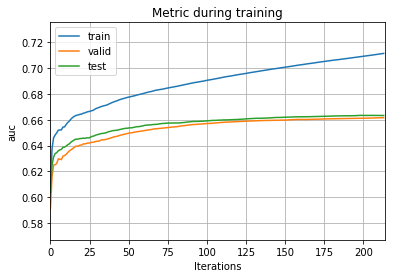

In [110]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

Plotting feature importances...


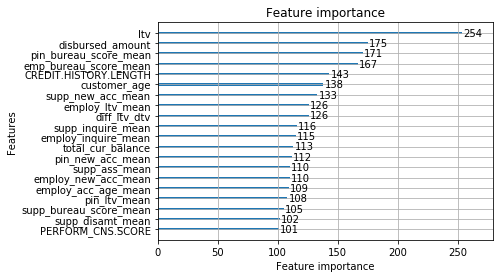

In [111]:
print('Plotting feature importances...')
ax = lgb.plot_importance(LGB_model, max_num_features=20)
plt.show()

In [112]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(solver='lbfgs',verbose=1)
LR_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False)

In [113]:
print_scores('XGboost',XGB_model)

Scores for XGboost model

Valid Threshold Cutoff: [0.21451594]

Test Threshold Cutoff: [0.2164382]

Valid AUC : 0.658
Test AUC : 0.661

Valid Accuracy: 0.614

Confusion Matrix for validation set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1173   935     2108
1.0         336   256      592
__all__    1509  1191     2700

Test Accuracy: 0.615

Confusion Matrix for Test set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1005   834     1839
1.0         334   263      597
__all__    1339  1097     2436

Valid Recall Score: 0.614
Test Recall Score: 0.615

Valid Precision Score: 0.341
Test Precision Score: 0.372

Valid F1 Score: 0.438
Test F1 Score: 0.464


In [114]:
print_scores('Random Forest', RF_model)

Scores for Random Forest model

Valid Threshold Cutoff: [0.2316]

Test Threshold Cutoff: [0.234]

Valid AUC : 0.629
Test AUC : 0.63

Valid Accuracy: 0.598

Confusion Matrix for validation set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1160   948     2108
1.0         329   263      592
__all__    1489  1211     2700

Test Accuracy: 0.597

Confusion Matrix for Test set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1007   832     1839
1.0         334   263      597
__all__    1341  1095     2436

Valid Recall Score: 0.595
Test Recall Score: 0.589

Valid Precision Score: 0.325
Test Precision Score: 0.353

Valid F1 Score: 0.421
Test F1 Score: 0.442


In [115]:
print_scores('Catboost', CB_model_full)

Scores for Catboost model

Valid Threshold Cutoff: [0.1615834597743524]

Test Threshold Cutoff: [0.16480150002984678]

Valid AUC : 0.697
Test AUC : 0.699

Valid Accuracy: 0.638

Confusion Matrix for validation set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1161   947     2108
1.0         355   237      592
__all__    1516  1184     2700

Test Accuracy: 0.642

Confusion Matrix for Test set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1022   817     1839
1.0         326   271      597
__all__    1348  1088     2436

Valid Recall Score: 0.638
Test Recall Score: 0.642

Valid Precision Score: 0.364
Test Precision Score: 0.4

Valid F1 Score: 0.464
Test F1 Score: 0.492


In [116]:
print_scores('Light GBM',LGB_model)

Scores for Light GBM model

Valid Threshold Cutoff: [0.21401891508413573]

Test Threshold Cutoff: [0.21716086387384995]

Valid AUC : 0.661
Test AUC : 0.663

Valid Accuracy: 0.614

Confusion Matrix for validation set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1170   938     2108
1.0         334   258      592
__all__    1504  1196     2700

Test Accuracy: 0.621

Confusion Matrix for Test set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1022   817     1839
1.0         339   258      597
__all__    1361  1075     2436

Valid Recall Score: 0.614
Test Recall Score: 0.62

Valid Precision Score: 0.34
Test Precision Score: 0.378

Valid F1 Score: 0.438
Test F1 Score: 0.47


In [117]:
print_scores('Logistic Regression',LR_model)

Scores for Logistic Regression model

Valid Threshold Cutoff: [0.21807336686215636]

Test Threshold Cutoff: [0.22082549129796536]

Valid AUC : 0.637
Test AUC : 0.639

Valid Accuracy: 0.598

Confusion Matrix for validation set

Predicted   0.0   1.0  __all__
Actual                        
0.0        1122   986     2108
1.0         331   261      592
__all__    1453  1247     2700

Test Accuracy: 0.601

Confusion Matrix for Test set

Predicted   0.0   1.0  __all__
Actual                        
0.0         981   858     1839
1.0         322   275      597
__all__    1303  1133     2436

Valid Recall Score: 0.598
Test Recall Score: 0.601

Valid Precision Score: 0.325
Test Precision Score: 0.358

Valid F1 Score: 0.421
Test F1 Score: 0.449


In [123]:
#imp = Imputer(strategy = 'mean', axis = 0)

#test_df[num_cols] = scaler.fit_transform(imp.fit_transform(test_df[num_cols]))


test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].median())

test_df[num_cols] = scaler.fit_transform(test_df[num_cols])

In [124]:
display_all(test_df.head())

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,customer_age,Employment.Type_NA,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,employ_delinq_mean,id_delinq_mean,bc_delinq_mean,supp_new_acc_mean,pin_new_acc_mean,employ_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,employ_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,pin_acc_age_mean,employ_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,employ_ltv_mean,emptype_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,pin_ass_mean,employ_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
233154,655269,-0.190835,-0.984765,1.035355,67,45,Salaried,6,-0.765147,-0.411825,-0.265934,-0.671531,-0.599485,-0.349935,1.023422,False,0.317868,0.0,No History,-0.493006,0.625459,1.023150,-0.880551,0.630029,0.722201,0.636577,0.837588,-0.413269,-0.416792,-0.533156,-0.988867,1.187158,-0.439624,-0.132861,-0.562128,-0.080681,0.085263,-0.201392,-0.934599,0.531797,1.773745,0.715195,0.822398,1.664568,-0.50797,1.402141,1.342500,0.959480,0.446542,1.676630,0.371946,0.719927,1.573261,1.128330,-0.581841,-0.047962,-0.868752,-0.159996,-0.926933,-0.111303,-0.580480,-0.861617,-0.734229,-0.612099,-0.866050,-0.648131,-0.565935,-0.434047,-0.538756,0.003414,-0.01475,-0.279813,-0.633838,-0.647914,-0.043779,-0.374426,0.370129,True,-0.017927,-0.330902,-0.384257,False
233155,723482,-0.010394,-1.017924,1.305065,67,45,Self employed,6,1.442619,0.962742,-0.265934,-0.020415,-0.120582,1.295666,-0.085439,False,0.066586,0.0,Very Low Risk,-0.493006,0.625459,1.023150,-0.880551,0.630029,0.722201,0.636577,-0.435359,-0.413269,-0.416792,-0.533156,-0.988867,1.187158,-0.439624,-0.132861,-0.290352,-0.080681,0.085263,-0.201392,0.941533,0.531797,1.773745,0.715195,0.822398,1.664568,-0.50797,1.402141,1.342500,0.959480,0.446542,1.676630,0.371946,0.719927,1.573261,-0.844475,-0.581841,-0.047962,-0.868752,-0.159996,-0.926933,-0.111303,-0.582593,-0.861617,-0.734229,-0.612099,-0.866050,0.043810,0.045878,-0.118468,1.144716,0.003504,-0.01152,-0.279813,0.794073,0.789376,-0.043779,-0.004497,0.370129,True,-0.017927,-0.014430,-0.384257,False
233156,758529,0.855813,0.758128,0.422716,78,86,Salaried,4,-0.765147,-0.411825,-0.265934,-0.671531,-0.599485,-0.349935,-1.194300,False,0.350774,0.0,No History,1.962020,-0.931088,-0.007391,0.782521,0.014234,0.446691,-1.117593,0.837588,1.573553,-0.677518,-0.522630,0.322029,-0.791136,-0.759833,0.341771,-0.562128,-0.332891,-0.119231,-0.694383,-0.934599,-0.545745,0.068577,0.004011,0.077567,-0.568366,-0.65339,0.396973,-0.525827,-0.858872,-0.101035,0.005251,0.658669,0.541528,0.706350,1.128330,-0.338795,0.560092,0.053341,0.405585,1.013824,-0.983254,-0.580480,-0.066801,0.339090,0.152655,-1.035629,-0.648131,-0.565935,-0.434047,-0.538756,0.003414,-0.01475,-0.279813,-0.633838,-0.647914,-0.043779,-0.374426,0.370129,True,-0.017927,-0.330902,-0.384257,True
233157,763449,-0.773657,-0.956391,0.112226,78,45,Self employed,4,-0.765147,-0.411825,-0.265934,1.688767,0.557864,-0.349935,1.023422,False,0.548210,0.0,Not Scored,-0.493006,-0.931088,-1.264315,-0.880551,-0.652501,0.446691,-1.117593,-0.435359,-0.413269,-0.677518,-0.729189,-0.988867,-1.102588,-0.759833,-0.132861,-0.354831,-1.044989,-0.71

In [125]:
test_df[cat_columns] = test_df[cat_columns].astype('str')

In [126]:
final_test = test_df.drop('UniqueID', axis=1)

In [127]:
final_test.shape, cv_X.shape

((112392, 81), (233154, 81))

In [128]:
submission = pd.DataFrame()
submission['UniqueID'] = test_df['UniqueID']
submission['loan_default'] = CB_model_full.predict_proba(final_test)[:,1]
submission.shape

(112392, 2)

In [129]:
submission.head()

,UniqueID,loan_default
233154,655269,0.267016
233155,723482,0.348378
233156,758529,0.314835
233157,763449,0.285382
233158,708663,0.355422


In [130]:
submission['loan_default'].sum(), submission['loan_default'].mean()

(24637.977446812274, 0.21921469007413583)

In [131]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
submission.to_csv(f'{PATH}Submission_{file_timestamp}.csv', index=False)